# PIT for Flows
Project idea based on [this paper](https://arxiv.org/abs/2102.10473). 

Using the `nflows` library for flow implementations.

In [1]:
import torch
import torch.distributions as D
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

from nde.train import train
from nde.flows import construct_nsf, construct_maf, count_parameters
from plot import plot_pdf_1D, plot_cdf_1D, PP_plot_1D, plot_2d_pdf_contours

## Context 
We have access to samples from the true distribution with **unknown density** $f_X$: $\quad X_1, \dots, X_n \sim f_X$

We can approximate it's c.d.f. empirically: $\quad F_X(x) = \mathbb{P}(X\leq x) \approx F_{n,X}(x) = \frac{1}{n}\sum_{i=1}^n\mathbb{1}_{\{X_i\leq x\}}$

Our estimator $f_Q$ is a *Normalizing Flow* whose density is **explicitly known**. It is defined by a base distribution $p_U$ (tipically gaussian) and a bijective transformation $T_{\phi}$: 
$$U\sim p_U \rightarrow Q=T_{\phi}(U) \sim f_Q$$ 
$$f_Q(q) = p_{U}\left(T_{\phi}^{-1}(q)\right)\left|\operatorname{det} J_{T_{\phi}^{-1}}(q)\right|$$ 

Note that we can also define it's c.d.f. explicitly: $\quad F_Q(q) = \mathbb{P}(Q\leq q) =\mathbb{P}(T_{\phi}(U)\leq q)=\mathbb{P}(U\leq T_{\phi}^{-1}(q))=F_U(T_{\phi}^{-1}(q))$

We wish to know evaluate our estimator, i.e. if our estimator matches the samples from the true distribution or not. We whish to do so in a **frequentist way**, as this gives us a quantitative metric (the p-value) that is omnipresent (hence best understood) in bio-physical fields like neuroscience (or astro-physics).

## 1D PP-plots

### Probability Inverse Transform (PIT)

$$ PIT(f_{Q}, X) = F_{Q}(X)$$ 
$$r(\alpha) = \mathbb{P}\left[PIT(f_{Q}, X)\leq \alpha)\right] = F_{X}(F_{Q}^{-1}(\alpha))$$

Theorectically, if the flow is a perfect approximation of the true density ($f_Q = f_X$), then the distribution of the PIT follows a uniform distribution: 

$$PIT(f_{Q}, X) = F_{X}(X) \sim \mathcal{U}(0,1)$$ 
$$r(\alpha) = F_{X}(F_{X}^{-1}(\alpha)) = \alpha$$

The PP-plot should show show the identity function. Deformations indicate bias (mean) and/or dispersion (variance).
- x-axis: $\alpha \in [0,1]$
- y-axis: $\hat{r}_n(\alpha) = \mathbb{P}_n\left[PIT(f_{Q}, X)< \alpha)\right] = F_{n,X}(F_{Q}^{-1}(\alpha))$ where $F_{n,X}$ is the empirical approximation of $F_X$ using samples $X_1, \dots X_n$ of the true distribution.

### PP-plots for untrained vs. trained flows
In the code below, we will show the pp-plot before and after the training of a flow for different 1D target "true distributions". 

In [95]:
# Target distributions 

# Gaussian 
mean = 2.
std = 1.
norm_dist = D.Normal(mean, std)

# Gaussian Mixture Model with 2 equally weighted gaussian distributions
mix = D.Categorical(torch.ones(2,))
comp = D.Normal(torch.FloatTensor([-2,2]), torch.rand(2,))
gmm_dist = D.MixtureSameFamily(mix, comp)

# Exponential distribution
rate = 1
exp_dist = D.Exponential(rate)

target_dists = {'gaussian': norm_dist, 'gmm': gmm_dist, 'exp': exp_dist}

In [96]:
# Get train and test samples: 
# - train samples are used to train the flow, 
# - test samples are used to compute the empiriacal r(alpha).
target_dist = target_dists['gaussian']
x_samples = target_dist.sample((2000,))

test_size = int(0.1* len(x_samples))
train_size = len(x_samples) - test_size
train_set, test_set = torch.utils.data.random_split(x_samples, [train_size, test_size])
x_samples_train, x_samples_test = train_set[:].reshape(-1,1), test_set[:].reshape(-1,1)
print('NB training samples: ', x_samples_train.shape)
print('NB test samples: ', x_samples_test.shape)

NB training samples:  torch.Size([1800, 1])
NB test samples:  torch.Size([200, 1])


In [51]:
# Define Flow: NSF (1 layer, 50 hidden features)
nsf = construct_nsf(x_samples_train, z_score_x = False, num_transforms=1)

# Count parameters
print('NSF with 1 layer and 50 hidden features: ', str(count_parameters(nsf)), 'parameters.')

NSF with 1 layer and 50 hidden features:  11731 parameters.


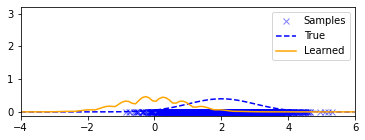

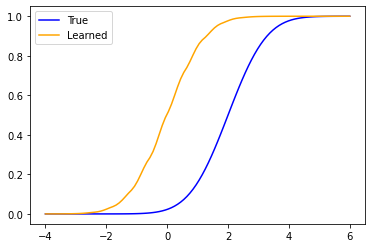

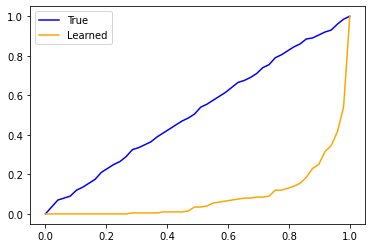

In [10]:
# PLOT TARGET VS. FLOW BEFORE TRAINING
plot_pdf_1D(target_dist, x_samples, flow=nsf, x_i=-4, x_f=6) # Density
plot_cdf_1D(target_dist,flow=nsf, x_i=-4, x_f=6) # CDF
PP_plot_1D(target_dist, x_samples_test, flow=nsf) # PP


Before training, the flow does not fit the target distribution. This is visualized in the pp-plot above with the deviations of the orange curve from the blue one. The blue curve indeed shows the identity function (or something really close) as it corresponds to the case where we evaluate the c.d.f. of the true density in the samples of the same true density:

$$ X_i \sim f_X \rightarrow F_X(X_i) \sim \mathcal{U}(0,1) $$

Let's see if after training the flow matches the true distribution, in which case, the orange curve should also fit the identity.

In [11]:
# Train Flow
best_val_loss, epochs = train(nsf, x_samples_train, num_epochs=2000, batch_size=10, lr=0.005, validation=True, plot=False, epochs_until_converge=20)
epochs

67

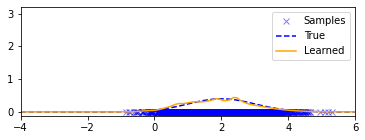

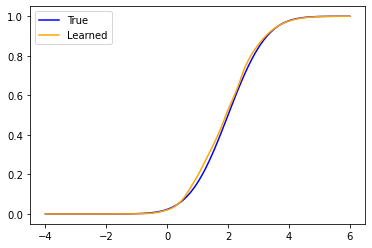

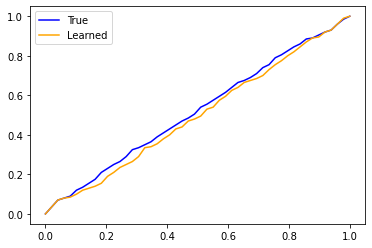

In [12]:
# PLOT TARGET VS. FLOW AFTER TRAINING
plot_pdf_1D(target_dist, x_samples, flow=nsf, x_i=-4, x_f=6) # Density
plot_cdf_1D(target_dist,flow=nsf, x_i=-4, x_f=6) # CDF
PP_plot_1D(target_dist, x_samples_test, flow=nsf) #PP

After training the flow matches the true density. Indeed the PP-plot shows that the orange curve is now close to the blue one and thus also corresponds to the identity function:

$$ X_i \sim f_X \quad \text{and} \quad f_Q \simeq f_X \rightarrow F_Q(X_i) \sim \mathcal{U}(0,1)$$

We don't need to have access to the explicit form of the true density to validate our estimator. We just need samples from it and see wheather $F_{n,X}\circ F_Q^{-1}$ matches the identity function or not. 

### Validation: Frequentist testing
The curve of the flow is never a perfect match to the identity, as we are looking at the empirical c.d.f $F_{n,X}$ of the true density $f_X$, i.e. using a limited amount of data, the $X_1, \dots X_n$. 
Therefore, we need a quantity to evaluate if we are *close enough*. 

The paper uses a frequentist approach with the following test statistic: 
$$ \hat{T}_{n,m} = \frac{1}{m}\sum_{i=1}^m(\alpha_i - \hat{r}_{n}(\alpha_i))^2$$
If $n=+\infty$ and $f_{Q} = f_X$, than $T$ should be zero. 

*What is a sufficiently small value for $\hat{T}_{n,m}$?* In the frequentist setting we use a hypothethis test to answer that question: 

The null hyptothethis is $H_0 = (f_{Q} = f_X)$ and we wish to evaluate $\mathbb{P}(T \mid H_0)$. This value should be small for large values of $T$. 

For a given value $\hat{T}_{n,m}$ obtained with our data and flow, the null hypothethis is rejected if the p-value is smaller than a given confidence level $\alpha_c$ ($= 0.95$ for example):
$$p=\mathbb{P}(T>\hat{T}_{n,m}\mid H_0) < 1-\alpha_c$$

This is equivalent to saying that $\hat{T}_{n,m}$ is higher than the critical value $T_c$ defined by $\mathbb{P}(T > T_c\mid H_0)= 1-\alpha_c$ (or $\mathbb{P}(T\leq T_c\mid H_0)= \alpha_c$). 

### Contributions
- I implemented a code that plots the PP-plot for (trained) 1D flows. Easier than doing empirical approximations of $F_Q$.
- We found an analytic expression of $\mathbb{P}( T \mid H_0)$ making the hypothesis test straight forward.

## Multivariate Case 

### Non-uniform PIT
Let's show that $F_X(X)$ is not generally uniformly distributed in the multivariate case.

Consider a bivariate gaussian distribution: $f_X = \mathcal{N}(\mu,\Sigma)$ where $\mu = [\mu_1, \mu_2]$ and 
$\Sigma = \begin{pmatrix} \sigma_{1}^2 & \rho \sigma_1 \sigma_2\\ \rho \sigma_1 \sigma_2 & \sigma_{2}^2 \end{pmatrix}$.


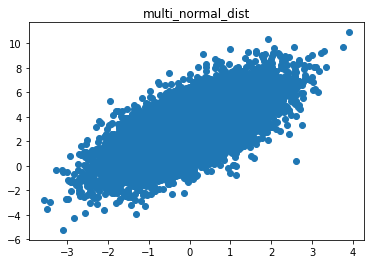

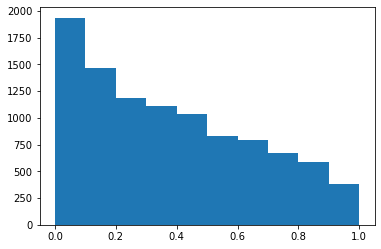

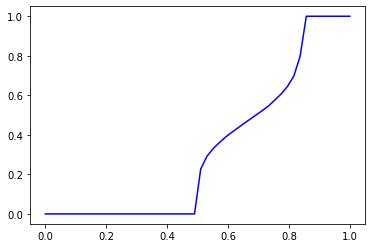

In [336]:
from scipy.stats import multivariate_normal as mvn
import numpy as np

# Parameters of the distribution
mu_1 = 0
mu_2 = 3
sigma_1 = 1
sigma_2 = 2
rho = 0.7

# True distribution: 2d gaussian
mean = np.array([mu_1,mu_2])
covariance = np.array([[sigma_1**2, rho*sigma_1*sigma_2],[rho*sigma_1*sigma_2, sigma_2**2]])
multi_normal_dist = mvn(mean=mean, cov=covariance)

# Plot samples 
n = 10_000 # nb samples 
samples_true = multi_normal_dist.rvs(n)
plt.scatter(x=samples_true[:,0], y=samples_true[:,1]) 
plt.title('multi_normal_dist')
plt.show()
# plot distribution of PIT(true_density, X_true)
plt.hist(multi_normal_dist.cdf(samples_true))
plt.show()
# plot pp_plot
alphas = np.linspace(0,1)
F = multi_normal_dist.cdf(samples_true)
z_true = [np.mean(F < alpha) for alpha in alphas]
plt.plot(alphas, z, color='blue')
plt.show()

The pp-plot of the true density does not show the identity function as it would in 1D. 

### Univariate Marginals

With the same notations as before, we can define the marginals of our bivariate gaussian:

$$ f_{X_1} = \mathcal{N}(\mu_1, \sigma_1^2), \quad f_{X_2} = \mathcal{N}(\mu_2, \sigma_2^2)$$

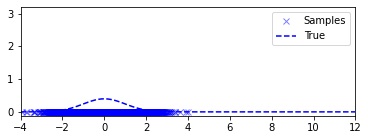

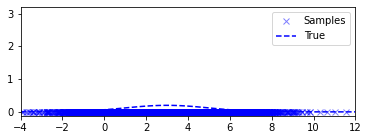

In [337]:
# Marginals 
marginal_1 = D.Normal(mu_1, sigma_1)
marginal_2 = D.Normal(mu_2, sigma_2)
samples_1 = marginal_1.sample((n,))
samples_2 = marginal_2.sample((n,))
plot_pdf_1D(marginal_1, samples_1, -4, 12)
plt.show()
plot_pdf_1D(marginal_2, samples_2, -4, 12)
plt.show()


Let's look at an estimator with same mean and marginals but different covariance matrix: this is not a good estimator.

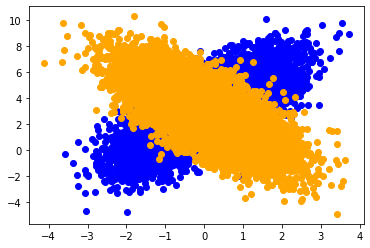

In [339]:
# ESTIMATOR DIST 
rho_est = -rho
covariance_est = np.array([[sigma_1**2, rho_est*sigma_1*sigma_2],[rho_est*sigma_1*sigma_2, sigma_2**2]])
est = mvn(mean=mean, cov=covariance_est)

# Plot samples 
colors = ['blue', 'orange']
for dist, color in zip([multi_normal_dist, est], colors):   
    samples = dist.rvs(n)
    plt.scatter(x=samples[:,0], y=samples[:,1], color=color) 
plt.show()

We can see that the distributions do not match! Let's look at the univariate marginals.

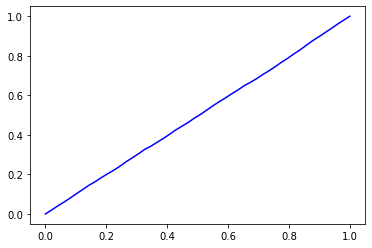

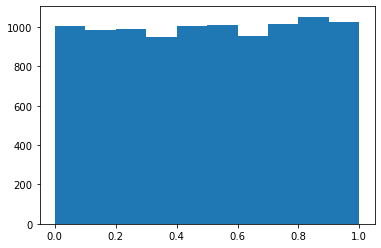

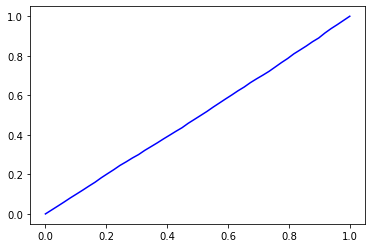

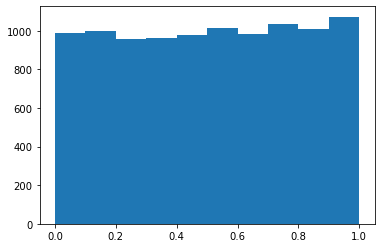

In [340]:
from plot import PP_vals
alphas = np.linspace(0,1)
# PP-plot for Marginal 1
z = PP_vals(marginal_1.cdf, torch.Tensor(samples_true[:,0]), alphas)
plt.plot(alphas, z, color='blue')
plt.show()
plt.hist(marginal_1.cdf(torch.Tensor(samples_true[:,0])).numpy())
plt.show()
# PP-plot for Marginal 2
z = PP_vals(marginal_2.cdf, torch.Tensor(samples_true[:,1]), alphas)
plt.plot(alphas, z, color='blue')
plt.show()
plt.hist(marginal_2.cdf(torch.Tensor(samples_true[:,1])).numpy())
plt.show()

The pp-plots show the identity function, i.e. the marginal test passes: we need a way to take into account the correlations when generalizing the PIT to the multivariate case! 

### Univariate Conditionals
(cf. [Remarks on a Multivariate Transformation](https://www.jstor.org/stable/2236692))

#### Theory
Assumtion: our multivariate distribution $f_X$ is absolutely continuous. 
There exists a transformation $T$ that turns our samples $X_1,\dots, X_d$ into variables $Z_1, \dots, Z_d$ which are uniformly and independently distributed on $[0,1]$:
$$ Z = TX \sim \mathcal{U}([0,1]^d) \quad \text{and} \quad Z_i \sim \mathcal{U}(0,1) \quad \text{i.i.d.}$$
It is given by:
$$
\begin{aligned}
&z_{1}=P\left\{X_{1} \leqq x_{1}\right\}=F_{1}\left(x_{1}\right) \\
&z_{2}=P\left\{X_{2} \leqq x_{2} \mid X_{1}=x_{1}\right\}=F_{2}\left(x_{2} \mid x_{1}\right) \\
&\vdots \\
&z_{d}=P\left\{X_{d} \leqq x_{d} \mid x_{d-1}=x_{d-1}, \cdots, X_{1}=x_{1}\right\}=F_{d}\left(x_{d} \mid x_{d-1}, \cdots, x_{1}\right) .
\end{aligned}
$$

#### IDEA (with Flows)
Use the MAF flow-architexture (that gives us access to the conditionals) to do this transformation and compare test the transformaed samples against the uniform distribution. 

#### Simple Gaussian Case (without Flows)
In the gaussian case, this transformation can be explicitly computed. 

Let's look at the 2D case we have been considering for now: $f_X = \mathcal{N}(\mu,\Sigma)$ where $\mu = [\mu_1, \mu_2]$ and 
$\Sigma = \begin{pmatrix} \sigma_{1}^2 & \rho \sigma_1 \sigma_2\\ \rho \sigma_1 \sigma_2 & \sigma_{2}^2 \end{pmatrix}$.

The transformation can be written as:
$$
\begin{gathered}
Z_1 = F_{1}\left(x_{1}\right)=\Phi\left(\frac{x_{1}-\mu_{1}}{\sigma_{1}}\right), \\
Z_2 = F_{2}\left(x_{2} \mid x_{1}\right)=\Phi\left(\frac{x_{2}-(\mu_{2}+\frac{\rho \sigma_{2}}{\sigma_{1}}\left(x_{1}-\mu_{1}\right))}{\sigma_{2} \sqrt{1-\rho^{2}}}\right) .
\end{gathered}
$$

***CAREFUL: there is a big typo in the paper when they show this formula!*** They are parantheses when substracting the mean of the conditional from $x_2$ and the role of $\sigma_1$ and $\sigma_2$ in the numerator have to be exchanged.

Let's look at the code and pp-plots.

In [133]:
from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm, uniform

# Parameters of the distribution
mu_1 = 0
mu_2 = 3
sigma_1 = 1
sigma_2 = 2
rho = 0.7
rho_est = -0.7

# True distribution: 2d gaussian
mean = np.array([mu_1,mu_2])
covariance = np.array([[sigma_1**2, rho*sigma_1*sigma_2],[rho*sigma_1*sigma_2, sigma_2**2]])
multi_normal_dist = mvn(mean=mean, cov=covariance)

# "Estimated distribution": 2d gaussian with same mean and marginals but different correlation coefficient
mean_est = np.array([mu_1,mu_2])
covariance_est = np.array([[sigma_1**2, rho_est*sigma_1*sigma_2],[rho_est*sigma_1*sigma_2, sigma_2**2]])
est = mvn(mean=mean_est, cov=covariance_est)

# Bivariate and marginal samples
n = 10_000 # nb samples 
samples_true = multi_normal_dist.rvs(n)
X_1 = samples_true[:,0]
X_2 = samples_true[:,1]

# Transformations with true distribution
Z_1 = norm.cdf((X_1 - mu_1) / sigma_1)
Z_2 = norm.cdf((X_2 - mu_2 - rho*sigma_2/sigma_1 * (X_1-mu_1)) / (sigma_2*np.sqrt(1-rho**2))) # F_true(X_2 | X_1)

# Transformations with estimated distribution
Z_1_est = norm.cdf((X_1 - mu_1) / sigma_1)
Z_2_est = norm.cdf((X_2 - mu_2 - rho_est*sigma_2/sigma_1 * (X_1-mu_1)) / (sigma_2*np.sqrt(1-rho_est**2))) # F_est(X_2 | X_1)

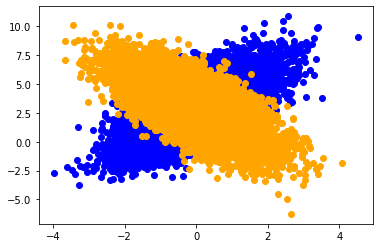

In [134]:
# plot distribution samples
plt.scatter(X_1,X_2, color='blue')
samples_est = est.rvs(n)
plt.scatter(samples_est[:,0], samples_est[:,1], color='orange')
plt.show()

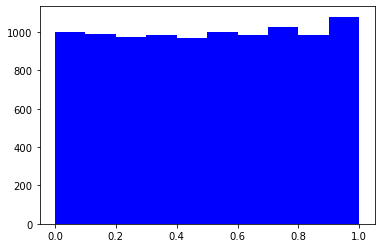

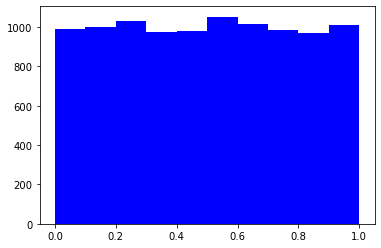

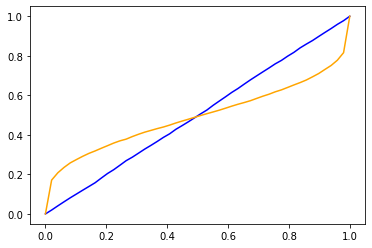

In [135]:
# Plot samples 
colors = ['blue', 'orange']

# plot distribution as hist : check if ground truth is uniform
plt.hist(Z_1, color=colors[0]) # of PIT(true_density, X_true)
plt.show()
plt.hist(Z_2, color=colors[0]) # of PIT(true_density, X_true)
plt.show()

# plot pp_plot
alphas = np.linspace(0,1)
z_true = [np.mean(Z_2 < alpha) for alpha in alphas]
z_est = [np.mean(Z_2_est < alpha) for alpha in alphas]
plt.plot(alphas, z_true, color=colors[0]) # of true density
plt.plot(alphas, z_est, color=colors[1]) # of estimator
plt.show()

The histograms show that the transformation obtained with the parameters of the true gaussian distribution gives us uniformly distributed variables: 

$$Z_1 = T_{true,1}(X)=F_1(X_1) \sim \mathcal{U}(0,1) \quad \text{and} \quad Z_2 = T_{true,2}(X)=F_2(X_2 \mid X_1) \sim \mathcal{U}(0,1)$$

We are especially interested in the conditional case $X_2 \mid X_1$ (see previous section for the marginal case $X_1$) for which we show the pp-plot. The true distribution recovers the identity function, wheras the "estimator" - only differing by the correlation coefficient - fails to do so. 

We have a method that gives us **1D pp-plots for each dimension** based on the conditional distribution, **taking into account the correlations between variables.** 

A $\chi^2$-test (with d degrees of freedom) can be performed by summing over all elements to test the validity of the estimator on the entire d-dimentional space. 

## Application to MAF with 1 transformation layer

We will use the transformation of the flow to transform the samples of our true distribution. We will then apply the c.d.f. of a normal distribution to each 'gaussianized' variable and check if the resulting variables follow a uniform distribution: 

$$ U_i = T_{\phi,i}^{-1}(X), \quad Z_i = F_{norm}(U_i)$$

If the flow is a good estimate of the true distribution, $U_i$ should follow the base distribution $p_U$ - a standard normal distribution - and thus $Z_i$ should follow a uniform distribution. In other words, we check if the flow can correctly transform our multivariate distribution into normally distributed ones. 

We can define the following test statistic for the null hyptothesis $\mathcal{H}_0 = (f_Q = f_X) = (T_{\phi}(U) \sim f_X) = (T_{\phi}{-1}(X) \sim p_U = \mathcal{N}(0,1))$:

$$ Y = \sum F_{norm}^{-1}(Z_i) \quad \text{s.t.} \quad Y \mid \mathcal{H}_0 \sim \chi^2(d)$$ 

$$ F_{\chi^2}(Y \mid \mathcal{H}_0) \sim \mathcal{U}(0,1)$$

***CAREFUL:** The base distribution must be a standard normal, otherwise it doesn't work! At least the $U_i$ have to **i.i.d with an explicitly computable c.d.f.***


In [139]:
# Define target distribution
means = torch.FloatTensor(mean)  # Defined in previous section
covs = torch.FloatTensor(covariance)  # Defined in previous section
target_dist = D.multivariate_normal.MultivariateNormal(means, covs) 
x_samples = target_dist.sample((2000,))

# # Blobs:2D Gaussian Mixture Model with 3 equally weighted gaussian distributions
# mix = D.Categorical(torch.ones(3,))
# gmm_means = torch.FloatTensor([[2., 4.], [ 8.,  10.], [ 10., 4.]])
# gmm_stds = torch.eye(2) 
# comp = D.multivariate_normal.MultivariateNormal(gmm_means, gmm_stds)
# target_dist = D.mixture_same_family.MixtureSameFamily(mix, comp)
# x_samples = target_dist.sample((2000,))


# Get train and test samples: 
# - train samples are used to train the flow, 
# - test samples are used to compute the empirical r(alpha).
test_size = int(0.1* len(x_samples))
train_size = len(x_samples) - test_size
train_set, test_set = torch.utils.data.random_split(x_samples, [train_size, test_size])
x_samples_train, x_samples_test = train_set[:], test_set[:]
print('NB training samples: ', x_samples_train.shape)
print('NB test samples: ', x_samples_test.shape)

NB training samples:  torch.Size([1800, 2])
NB test samples:  torch.Size([200, 2])


In [227]:
# Define Flow: MAF (1 layer, 50 hidden features)
maf = construct_maf(x_samples_train, 
    hidden_features=50, 
    context_features=None,
    num_layers=1, 
    random_permutation=False,
    standardize_transform = True,)

# Count parameters
print('MAF with 1 layer and 50 hidden features: ', str(count_parameters(maf)), 'parameters.')

MAF with 1 layer and 50 hidden features:  10554 parameters.


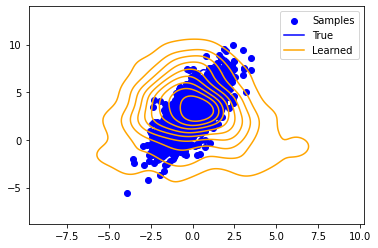

In [228]:
plot_2d_pdf_contours(target_dist, x_samples_train, maf)

In [221]:
# # Get MAF transformation
# MAF_transform = maf._transform._transforms[1]._transforms[1]

# autoregressive_params = MAF_transform.autoregressive_net(x_samples_test)
# unconstrained_scale, shift = MAF_transform._unconstrained_scale_and_shift(autoregressive_params)
# scale = F.softplus(unconstrained_scale) + MAF_transform._epsilon

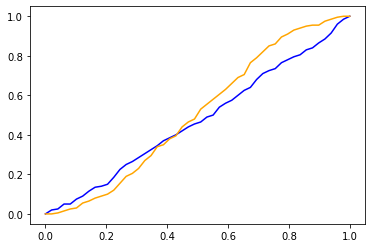

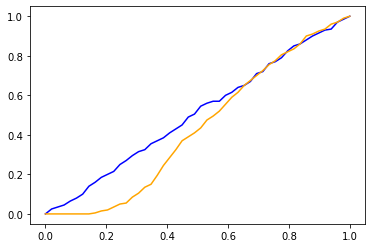

In [229]:
# Transformations with true distribution
X_1 = x_samples_test[:,0]
X_2 = x_samples_test[:,1]
Z_1 = norm.cdf((X_1 - mu_1) / sigma_1)
Z_2 = norm.cdf((X_2 - mu_2 - rho*sigma_2/sigma_1 * (X_1-mu_1)) / (sigma_2*np.sqrt(1-rho**2)))  # F_true(X_2 | X_1)

# MAF transformation
Z_1_maf = norm.cdf(maf._transform(x_samples_test)[0][:,0].detach().numpy()) # 1D
Z_2_maf = norm.cdf(maf._transform(x_samples_test)[0][:,1].detach().numpy()) # 1D

# plot pp_plot variable 1
alphas = np.linspace(0,1)
z_true = [np.mean(Z_1 < alpha) for alpha in alphas]
z_maf = [np.mean(Z_1_maf < alpha) for alpha in alphas]
plt.plot(alphas, z_true, color=colors[0]) # of true density
plt.plot(alphas, z_maf, color=colors[1]) # of estimator
plt.show()

# plot pp_plot variable 2
z_true = [np.mean(Z_2 < alpha) for alpha in alphas]
z_maf = [np.mean(Z_2_maf < alpha) for alpha in alphas]
plt.plot(alphas, z_true, color=colors[0]) # of true density
plt.plot(alphas, z_maf, color=colors[1]) # of estimator
plt.show()


Before training, our flow is not yet a good estimator of our true distribution. This is shown in the 2d plot of the sample contours and on the pp-plots of the transformed samples, which are far from the identity (blue line computed on the ground truth transformation). 

In [230]:
# Train Flow
best_val_loss, epochs = train(maf, x_samples_train, num_epochs=2000, batch_size=10, lr=0.005, validation=True, plot=False, epochs_until_converge=20)
epochs

60

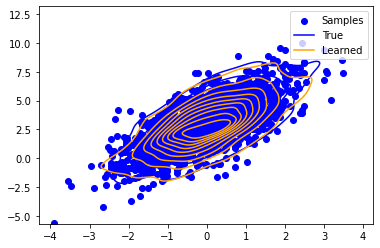

In [234]:
# Plot estimated distribution 
plot_2d_pdf_contours(target_dist, x_samples_train, maf)

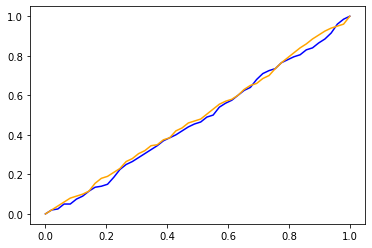

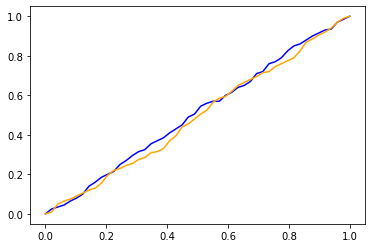

In [232]:
Z_1_maf = norm.cdf(maf._transform(x_samples_test)[0][:,0].detach().numpy())
Z_2_maf = norm.cdf(maf._transform(x_samples_test)[0][:,1].detach().numpy())

# plot pp_plot variable 1
alphas = np.linspace(0,1)
z_true = [np.mean(Z_1 < alpha) for alpha in alphas]
z_maf = [np.mean(Z_1_maf < alpha) for alpha in alphas]
plt.plot(alphas, z_true, color=colors[0])  # of true density
plt.plot(alphas, z_maf, color=colors[1])  # of estimator
plt.show()

# plot pp_plot variable 2
z_true = [np.mean(Z_2 < alpha) for alpha in alphas]
z_maf = [np.mean(Z_2_maf < alpha) for alpha in alphas]
plt.plot(alphas, z_true, color=colors[0])  # of true density
plt.plot(alphas, z_maf, color=colors[1])  # of estimator
plt.show()

After training, the contours match the training samples and the pp-plots (computed on the test samples) show a line that is close to the identity. 

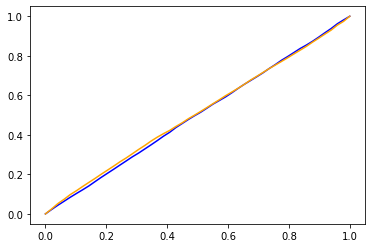

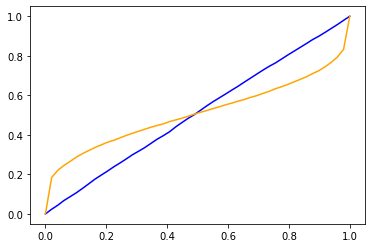

In [233]:
# Verify result on samples from a distribution that only differs by the correlation coefficient 
samples_false = torch.FloatTensor(samples_est) # defined in previous section

# Transformations with true distribution
X_1 = samples_est[:,0]
X_2 = samples_est[:,1]
Z_1 = norm.cdf((X_1 - mu_1) / sigma_1)
Z_2 = norm.cdf((X_2 - mu_2 - rho_est*sigma_2/sigma_1 * (X_1-mu_1)) / (sigma_2*np.sqrt(1-rho_est**2)))  # F_{true}(X_2 | X_1)

# Transformation from MAF trained to estimate a distribution with different correlation coefficient
Z_1_maf = norm.cdf(maf._transform(samples_false)[0][:,0].detach().numpy())
Z_2_maf = norm.cdf(maf._transform(samples_false)[0][:,1].detach().numpy())

# plot pp_plot variable 1
alphas = np.linspace(0,1)
z_true = [np.mean(Z_1 < alpha) for alpha in alphas]
z_maf = [np.mean(Z_1_maf < alpha) for alpha in alphas]
plt.plot(alphas, z_true, color=colors[0])  # of true density
plt.plot(alphas, z_maf, color=colors[1])  # of estimator
plt.show()

# plot pp_plot variable 2
z_true = [np.mean(Z_2 < alpha) for alpha in alphas]
z_maf = [np.mean(Z_2_maf < alpha) for alpha in alphas]
plt.plot(alphas, z_true, color=colors[0])  # of true density
plt.plot(alphas, z_maf, color=colors[1])  # of estimator
plt.show()

We verify our method on samples from a distribution that only differs by the correlation coefficient to be sure it really takes into account the correlations between variables. 

If we consider a MAF with one layer, the pp-plots show exactly the same plot as in the toy example where we explicitly wrote down the transformation for the false gaussian estimator (cf. previous section without flows): the identity function for the marginal in the first dimension, and the distorted orange curve for the conditional on the second dimension, indicating a mismatch of the estimated correlation and the one that is present within the data. 

The plots change with the number of layers, because of the permutations, but they do not fail to capture the correlation differences:
- 1 layer: correlation mismatch in dim 2
- 2 layers: correlation mismatch in dim 1
- 3 layers: correlation mismatch clearly visible in dim 2 but starts to appear in dim 1 alswell.

**QUESTIONS:**
- What do the permutations actually mean in terms of the transformation?
- How can we interpret the deviations from the identity function in each dimension if our flow has several layers (with permutations inbetween), or is not even a MAF, but a NSF for example?
- Is it possible to look at dependencies between to specific variables? e.g. what if i just want to validate my estimator on $F(X_3\mid X_1)$ and not $F(X_3\mid X_1, X_2)$? Would simply permuting $X_2$ and $X_3$ work? 

### About the distribution of $F_X(X)$ in $\mathbb{R}^d$
- It is characterized by the Kendall function $K_X(t)=P(F_X(X)\leq t)$
- Not generally uniform for $d>1$!
- The marginals are uniformally distributed: $F_{X_i}(X_i)\sim \mathcal{U}(0,1)$

**Sklars Theorem:** there exists a copula $C_X$ ([=joint d.f. with uniform margins](https://www.osg.or.at/download/files/%7BAB458C9E-20F7-4208-BE75-D340BFF444FE%7D/22_Fabrizio_Durante.pdf)) such that,

$$\forall x \in R^d, \quad F_X(x) = C_X(F_1(x_1), . . . , F_d(x_d))$$ 
$$\forall u \in [0,1]^d, \quad C(u_1, . . . , u_d) = F_X(F^{−1}_1(u_1), \dots, F^{−1}_d(u_d))$$

where $F_1, \dots, F_d$ are the univariate marginals of the joint c.d.f. $F_X$. 
- $C_X$ is unique if $F_1, \dots, F_d$ are continuous. 
- The Kendall function defines an equivalence class for copulas: $C_1 \equiv_K C_2 \iff K_1 = K_2$

**--> When considering flows, can we still say that $F_Q(X) = F_U(T_{\phi}^{-1}(X))$? Would this even be useful?**

### Validation Methods in $\mathbb{R}^d$
#### PP-plots in $\mathbb{R}^d$:
- **Univariate marginals:** can we explicitly compute them for flows?
However, we need a way to evaluate the entire joint distribution, otherwise we might fail to capture the nature of dependence among the marginals of a multivariate distribution (cf. [multivariate q-q plots](https://arxiv.org/pdf/1407.1212.pdf)).
 - **[PP-plots with copulas](https://hal-cea.archives-ouvertes.fr/cea-00440431/document):** gof test = multidimensional $\chi^2$-test. 
 Can we compute the copula? or the conditional cdfs? --> COP-PIT? (Pedro)
 - **PP-plot on univariate conditionals:** do we have access to the conditionals of the flow? and to samples of the conditionals of the true distribution? --> MAF flow-architecture
 
#### Other Methods
- High Density Regions (HDR): used in SBI literature as in [[1]](https://matheo.uliege.be/bitstream/2268.2/12993/6/report.pdf) + [code](https://github.com/montefiore-ai/hypothesis/blob/master/hypothesis/stat/constraint.py), [[2]](https://arxiv.org/abs/2110.06581) and mentioned in [[3]](https://arxiv.org/abs/2102.10473)
- [QQ-plots with spatial quantiles](https://arxiv.org/pdf/1407.1212.pdf)


**--> Is there something in these methods that can be easier with the flow expression? Are they good enough or do we need something else?**

#### OMAR:
- energy distance: reformluation of quantlie matching ($l_2$ distance between two c.d.f's as a classification task that can be generalized to the multivariate case.

#### Ideas
- Compare copulas: unique if marginals are continuous . We could compute the Archimedes copula associated to $K_X$ and $K_Q$ (which are unique) and see if they are the same. (empirical approx, not take advantage of the flow expression.. **OR flow for copulas**)
- Compare Kendall functions: is there a test statistic? 
- VAE literature?
- Characteristic function?

#### Comments:

- Proper Scoring Rules (e.g. brier) are usually used for calibration, but need ground-truth..? Can be used on ratio estimation!
- QQ-plots vs. PP-plots (see [this example](https://stats.stackexchange.com/questions/92141/pp-plots-vs-qq-plots))

### TODO
**Is there a need for other methods to evaluate HNN posteriors? In terms of implementation complexity and/or expressivity (marginals don't include all the information..)**

- Are there any examples where people use marginals only to validate their posterior? Is there really nothing else that has been used in neuroscience for now?
- Is there an example where the posteriors are really complex, like where correlations between some parameters play a big role and the marginals would not capture the whole information?


#### HDR
- Implementation of HDR: are there complications? Is there something to do with the flow expression? 
- Is HDR a good method? as informative as **pp-plots in 1d**? Are there associated test-statistics to do frequentist testing?

#### QQ-plot
- Implementation of multivariate QQ-plot: are there complications? Is there something to do with the flow expression?
- Compare to other methods. Is it as informative, or does it give us complementary information to the **pp-plot** and/or HDR?

**Find a toy-model to see where existing validation metrics fail (for HNN)!**


